<a href="https://colab.research.google.com/github/angeloken/Riset-I-smile/blob/main/riset_prediksi_listrik_ver_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from datetime import datetime
import requests
import tensorflow as tf
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:

df = pd.read_csv('/content/opsd_germany_daily.csv')

In [5]:
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [6]:
df = df[['Date','Consumption']]
df['Date'] = pd.to_datetime(df['Date'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
df.set_index(df['Date'],inplace=True)
df=df.drop(['Date'],axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4383 entries, 2006-01-01 to 2017-12-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  4383 non-null   float64
dtypes: float64(1)
memory usage: 68.5 KB


In [9]:
df

,Consumption
Date,
2006-01-01,1069.18400
2006-01-02,1380.52100
2006-01-03,1442.53300
2006-01-04,1457.21700
2006-01-05,1477.13100
...,...
2017-12-27,1263.94091
2017-12-28,1299.86398
2017-12-29,1295.08753


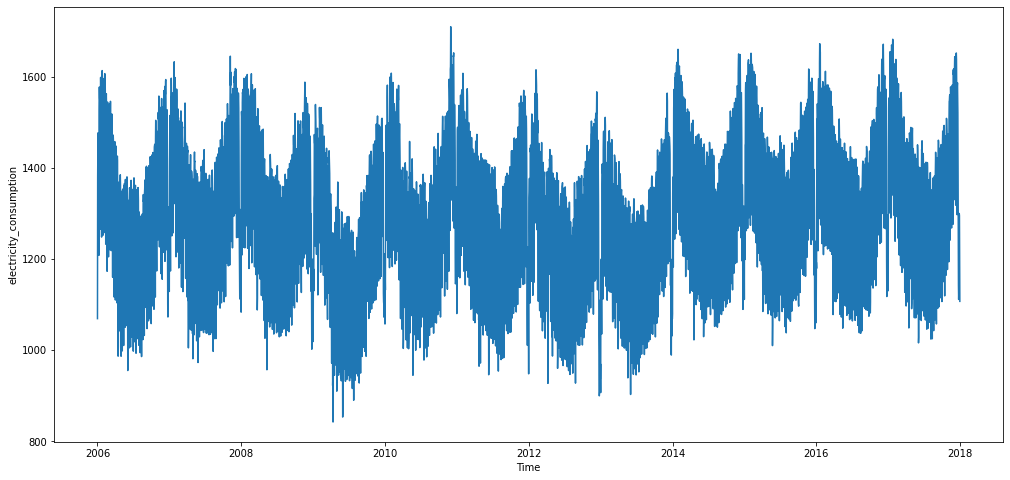

In [10]:
plt.figure(figsize=(17, 8))
plt.plot(df['Consumption'])
plt.xlabel('Time')
plt.ylabel('electricity_consumption')
plt.grid(False)
plt.show()

In [11]:
dataset = df.values

training_data_len = int(np.ceil( len(dataset) * .80))

training_data_len


3507

In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.26152682],
       [0.62055207],
       [0.6920626 ],
       ...,
       [0.52203255],
       [0.43019555],
       [0.30526767]])

In [13]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True,input_shape= (x_train.shape[1], 1)),
  tf.keras.layers.LSTM(64, return_sequences=False),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(x_train,y_train, epochs=100, callbacks=[lr_schedule])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
109/109 [==============================] - 10s 18ms/step - loss: 0.1708 - mae: 0.5529
Epoch 2/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1708 - mae: 0.5529
Epoch 3/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1708 - mae: 0.5528
Epoch 4/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1707 - mae: 0.5528
Epoch 5/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1707 - mae: 0.5527
Epoch 6/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1707 - mae: 0.5526
Epoch 7/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1706 - mae: 0.5525
Epoch 8/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1706 - mae: 0.5525
Epoch 9/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1705 - mae: 0.5524
Epoch 10/100
109/109 [==============================] - 2s 18ms/step - loss: 0.1705 - mae: 0.5522
Epoch 11/100
109/109 [======

In [15]:
# Create the testing data set
# Create a new array containing scaled values
test_data = scaled_data
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[30:, :]
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)


In [16]:
predictions = scaler.inverse_transform(predictions)

In [17]:
var=explained_variance_score(y_test, predictions) 

mae=mean_absolute_error(y_test, predictions)
mse=mean_squared_error (y_test, predictions)
rmse=np.sqrt(mse)
r2=r2_score(y_test,predictions)  
metric=[var,mae,mse,rmse,r2]
evaluate=['Explained variance','MAE','MSE','RMSE','R^2']
performance_evaluate=pd.DataFrame([evaluate,metric])
performance_evaluate

,0,1,2,3,4
0,Explained variance,MAE,MSE,RMSE,R^2
1,0.0980412,133.311,24846.9,157.629,0.0940048


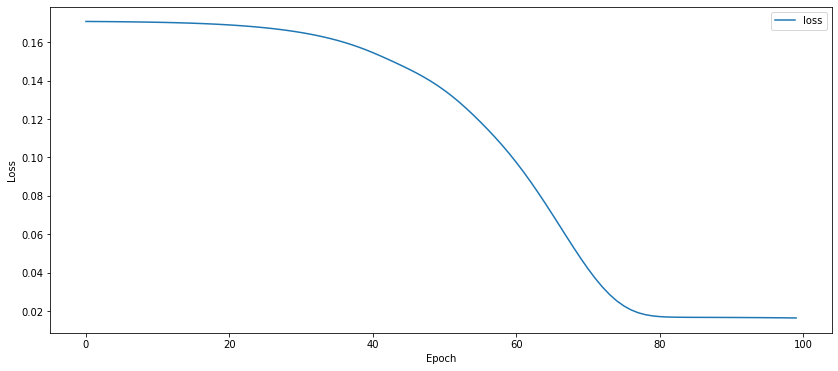

In [18]:
# Visualize the data
plt.figure(figsize=(14,6))
plt.plot(history.history["loss"], label="loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
# Plot the data
train = df[:training_data_len]
valid = df[30:]
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
predictions.shape

(4353, 1)

In [21]:
train.shape

(3507, 1)

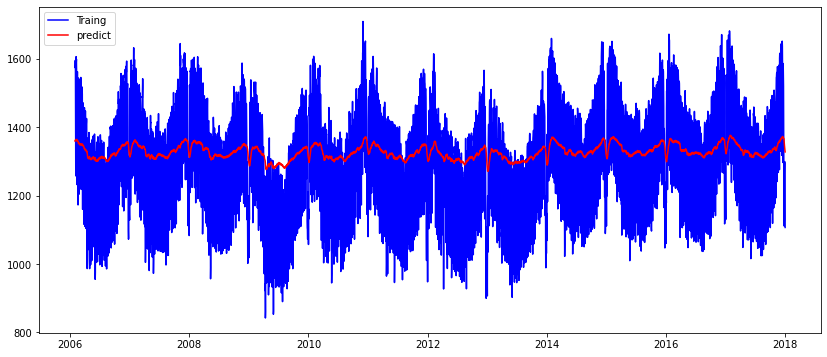

In [22]:
# Visualize the data
plt.figure(figsize=(14,6))
plt.plot(valid['Consumption'], label="Traing",c = "b")
plt.plot(valid['Predictions'], label="predict", c = "r")
plt.legend()
plt.show()

In [23]:
valid.tail()

,Consumption,Predictions
Date,,
2017-12-27,1263.94091,1346.104736
2017-12-28,1299.86398,1340.138794
2017-12-29,1295.08753,1335.445312
2017-12-30,1215.44897,1331.709717
2017-12-31,1107.11488,1328.023804
